# Simulação
Considerando que já temos a cinemática e a dinâmica do corpo em análise, podemos simulá-lo. Para organizar melhor os resultados anteriores para cada manipulador em análise, vamos criar uma classe que organiza e calcula esses resultados para um dado tipo de manipulador. Inicialmente, definimos todas as bilbiotecas que serão utilizadas e criamos a classe que representará o manipulador em análise.

In [1]:
# Blibliotecas utilizadas
import jdc
from IPython.display import HTML
from numpy import sin, cos, pi
import numpy as np
import dill, os, time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from scipy.integrate import odeint, solve_ivp
from scipy.misc import derivative
from sympy import symbols, pprint, simplify, Derivative, lambdify, Dummy
from sympy.physics.mechanics import *
from sympy.physics.mechanics.functions import inertia
dill.settings['recurse'] = True
        
class Manipulador1GdL:
    """Classe do Manipulador de 1 Grau de Liberdade

    * init_state: o estado inicial do manipulador [theta, omega] em graus,
        sendo theta e omega são a posição angular e velocidade angular do 
        do braço manipulador.
    """
    def __init__(self,
                 init_state = [0, 0],
                 L = 1.0,                     # Compriemnto do braço (m)
                 R = 0.5,                     # Distância até a Localização do C.M. do braço (m)
                 I = 0.12,                    # Momento de inércia do braço (kg.m^2)
                 M = 1.0,                     # Massa do braço (kg)
                 G = 9.8,                     # Aceleração da gravidade (m/s^2)
                 T = 0.0,                     # Torque aplicado
                 edo_method = 'LSODA',        # Método de resolução da EDO.
                                              # ('LSODA', 'RK45', 'RK23', 'Radau' or 'BDF')
                 origin = (0, 0)):
        self.edo_method = edo_method
        self.init_state = np.deg2rad(np.asarray(init_state, dtype='float'))
        self.num_params = (L, R, I, M, G)
        self.torque = T
        self.origin = origin
        # Converte o angulos em radianos e no referencia vertical
        self.thetas = []
        self.omegas = []
        self.time = []        
        self.rhs_lambdified = []
        # frames por segundo da animação
        self.fps = 1./60    
        self.solution_edo = False
        # Calcula a Dinâmica do Corpo
        self.solve_dynamics()       

## Dinâmica e Cinemática
Assim, foi criada duas funções que calculam a posição e dinâmica do manipulador baseando-se nos resultados obtidos na etapas anteriores (Diponíveis [aqui](https://github.com/Fernandohf/Robotica-Projetos/tree/master/1-Cinem%C3%A1tica) e [aqui](https://github.com/Fernandohf/Robotica-Projetos/tree/master/2-Din%C3%A2mica). A função `solve_dynamics` calcula e salva a equação de movimento do manipulador para as constantes definidas inicialmente e a função `position` retrna a posição dos elos para dados valores da coordenada generalizada.

In [2]:
%%add_to Manipulador1GdL
# Solução da Dinâmica do Manipulador
def solve_dynamics(self):    
    """Calcula a solução da dinâmica do manipulador e já coloca em
     formato pronto para ser calculado """
    # Variáveis Simbólicas do problema
    theta = dynamicsymbols('theta')
    dtheta = dynamicsymbols('theta', 1)
    tau = symbols('tau')
    symb_dynamics = (theta, dtheta, tau)

    l = symbols('l', positive = True)
    r = symbols('r', positive = True)
    m, g = symbols('m g')
    I_xx, I_yy, I_zz = symbols('I_{xx}, I_{yy}, I_{zz}') 
    symb_params = (l, r, I_zz, m, g)

    # Nome do arquivo salvo com a equação do movimento
    #here = os.path.dirname(os.path.realpath(__file__))
    file_name = ("\\models\\rotatingarm_dynamics_" + 
                "".join(str(e) + "_" for e in self.num_params) + ".data")
    # Verifica se a solução já foi calculada antes
    try:
        rhs = dill.load(open(file_name, "rb"))
        self.rhs_lambdified = rhs
        return
    except:
        print("Modelo dinâmico ainda não foi calculado para esses parâmetros. Aguarde...")
    initial_time = time.time()

    # Referenciais 
    B0 = ReferenceFrame('B0')                         # Referencial Inercial
    B1 = B0.orientnew('B1', 'Axis', [theta, B0.z])    # Referencial móvel: theta_1 em relação a B0.z 

    # Pontos e Centros de Massa
    O = Point('O')                                    # Origem
    O.set_vel(B0, 0)              
    CM = Point('CM')                                  # Centro de Massa
    CM.set_pos(O, r * B1.x)
    CM.v2pt_theory(O, B0, B1)

    # Corpos Rígidos
    E = RigidBody('E', CM, B1, m, (inertia(B1, I_xx, I_yy, I_zz), O)) 

    # Energia Potencial
    P = - m * g * B0.y
    r_CM = (r * B1.x).express(B0)
    E.potential_energy = r_CM.dot(P)

    # Forças/Momentos Generalizados
    FL = [(B1, tau * B0.z)]
    # Método de Lagrange
    L = Lagrangian(B0, E).simplify()
    LM = LagrangesMethod(L, [theta], frame=B0, forcelist = FL)        
    motion_eq = LM.form_lagranges_equations()
    rhs = LM.rhs()

    # Salva as Equação em formato fácil de se obter Solução já com os Parâmetros
    dummys = [Dummy() for i in symb_dynamics]
    rhs = msubs(rhs, dict(zip(symb_params, self.num_params)))
    dummydict = dict(zip(symb_dynamics, dummys))
    rhs = msubs(rhs, dummydict)

    # Lambdify as equações
    for f in rhs:
        self.rhs_lambdified.append(lambdify(dummys, f))

    # Salva as equações lambidificadas e já com as constantes subtituídas no disco
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    dill.dump(self.rhs_lambdified, open(file_name, "wb"))
    print("Modelo calculado e salvo em " + file_name + ".Tempo: " +
           str(time.time() - initial_time))

def position(self, theta):
    """ Retorna a posição (x,y) atual da ponta do manipulador"""
    L = self.num_params[0]
    x = np.cumsum([self.origin[0], L * cos(theta)])
    y = np.cumsum([self.origin[1], -L * sin(theta)])
    return (x, y)


## Resolver a Equação de Movimento
Como o método que calcula a dinâmica resulta em uma função utilizável pelo solver da EDO, podemos encontrar o resultado da EDO para um dado itervalo de forma simples. Como mostrado abaixo.

In [3]:
%%add_to Manipulador1GdL
 # Função utilizada pelo solver da EDO 
def f_ode(self, t, y):
    """"Função no formato utilizado pelo solver da EDO"""
    theta, omega = y
    T = self.torque
    # Lista com a conversão da equação diferencial do Sympy em função solucionável do Scipy
    return [f(theta, omega, T) for f in self.rhs_lambdified]

def solve_edo(self, dt = 20):
    """Executa solução para o modelo em um intervalor de tempo dt"""
    # Postos que a função será avaliada
    self.time = np.arange(0, dt, self.fps)
    # Solucionador padrão de EDO do Scipy
    solution = solve_ivp(self.f_ode, (0, dt), self.init_state, method=self.edo_method, t_eval=self.time)
    self.thetas = solution.y[0]
    self.omegas = solution.y[1]
    self.time = solution.t
    self.solution_edo = solution.success
    if not self.solution_edo:
        print("A EDO não pôde ser selecionada, verifique se a solução da dinâmica" +
              "do corpo já foi calculada através do método solve_dynamics().")

## Simulação
Por fim, definimos a função que cria a a simulação da classe em **Matplolib**.

Agora, só precisamos criar uma instancia da classe e simulá-la para um dado intervalo de tempo.

In [18]:
manipulador = Manipulador1GdL([0, 0], edo_method='RK45')
#manipulador.solve_dynamics()
manipulador.solve_edo(20)

<IPython.core.display.Javascript object>


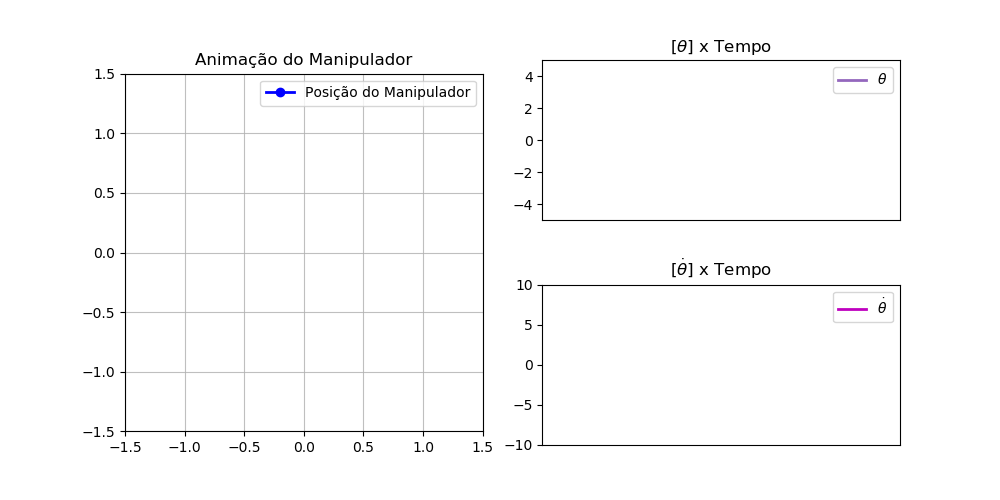

In [19]:
% matplotlib notebook
def simulate_model(manipulador):
    """Simula o manipulador a partir das equações dinâmicas"""
    # Verifica se existe solução calculada
    if not manipulador.solution_edo:
        print("As soluções da EDOs devem ser calculadas antes!")
        return

    #------ GRÁFICOS E ANIMAÇÃO ------#
    # Variáveis iniciais
    dt = manipulador.fps           # fps
    thetas = []             # Estados dos thetas a cada iteração
    omegas = []             # Estados dos omegas a cada iteração
    times = []              # Tempo de cada iteração

    # Figura
    fig = plt.figure(figsize=(10, 5))

    # Posição dos Subplots com animação
    time_max = 8
    grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.4)
    pos_anim = grid[0:, 0:-2]
    pos_state_1 = grid[0, 2:]
    pos_state_2 = grid[1, 2:]

    #Definição dos Subplots em sí
    sim_ax = fig.add_subplot(pos_anim, aspect='equal', autoscale_on=False,
                            xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
    sim_ax.grid(alpha=0.8)
    sim_ax.set_title("Animação do Manipulador")

    state_ax_1 = fig.add_subplot(pos_state_1, autoscale_on=False,
                            xlim=(0, time_max), ylim=(-5, 5))
    state_ax_1.set_title(r"[$\theta$] x Tempo")
    state_ax_1.get_xaxis().set_visible(False)

    state_ax_2 = fig.add_subplot(pos_state_2, autoscale_on=False,
                            xlim=(0, time_max), ylim=(-10, 10))
    state_ax_2.set_title(r"[$\dot{\theta}$] x Tempo")
    state_ax_2.get_xaxis().set_visible(False)

    # Objetos Desenhados
    line_anim, = sim_ax.plot([], [], 'bo-', lw=2, label="Posição do Manipulador")
    time_text = sim_ax.text(0.04, 0.04, '', transform=sim_ax.transAxes)
    sim_ax.legend()

    line_state_theta, = state_ax_1.plot([], [], 'tab:purple', lw=2, label=r"$\theta$")
    state_ax_1.legend()

    line_state_omega, = state_ax_2.plot([], [], 'm-', lw=2, label=r"$\dot{\theta}$")
    state_ax_2.legend()

    # Funções necessárias para a animação pelo matplolib
    def init():
        """initialize animation"""
        line_anim.set_data([], [])
        line_state_theta.set_data([], [])
        line_state_omega.set_data([], [])
        time_text.set_text('')

        return line_anim, line_state_theta, line_state_omega, time_text

    def animate(i):
        """perform animation step"""
        theta = manipulador.thetas[i]
        omega = manipulador.omegas[i]
        t_ = manipulador.time[i]
        # Atualiza os dados
        thetas.append(theta)
        omegas.append(omega)
        times.append(t_)
        xmin, xmax = state_ax_1.get_xlim()

        # Ajusta o eixo do tempo, x
        if t_ > xmax:
            state_ax_1.set_xlim((xmin, xmax * 2))
            state_ax_2.set_xlim((xmin, xmax * 2))
            state_ax_1.figure.canvas.draw()

        # Atualiza os objetos desenhados com os dados obtidos
        line_anim.set_data(self.position(theta))
        line_state_theta.set_data(times, thetas)
        line_state_omega.set_data(times, omegas)
        time_text.set_text('Tempo = %.1f' % t_)

        return line_anim, line_state_theta, line_state_omega, time_text

    # Exeuta a animação
    interval = 1000 * dt # Intervalo baseado em dt em ms
    fr = len(manipulador.time)
    ani = animation.FuncAnimation(fig, animate, frames=fr, blit=True, init_func=init)
    plt.show()
simulate_model(manipulador)

<IPython.core.display.Javascript object>


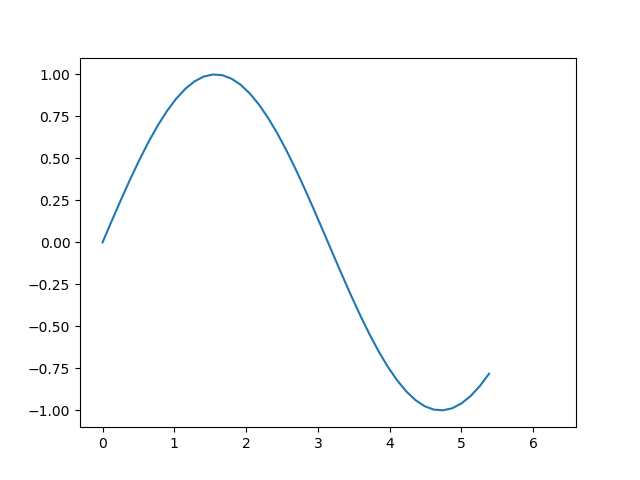

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

plt.show()